In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import io
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd

from PIL import Image, ImageFont, ImageDraw
from collections import defaultdict

%matplotlib inline

In [2]:
_ = np.seterr(divide='ignore', invalid='ignore')

In [3]:
SEED = 100

random.seed(SEED)

In [4]:
def display_pillow_image(image: Image):
    bio = io.BytesIO()
    image.save(bio, format='png')
    ipd.display(ipd.Image(bio.getvalue(), format='png'))

In [5]:
RELATIVE_FEATURES_PATH = "data/relative_features.csv"

In [6]:
FONT_PATH = "data/fonts/kirillica-nova-unicode.ttf"
ALPHABET = [
    "\u0430",
    "\u0431",
    "\u0432",
    "\u0433",
    "\u0434",
    "\u0454",
    "\u0436",
    "\u0455",
    "\u0437",
    "\u0438",
    "\u0456",
    "\u045B",
    "\u043A",
    "\u043B",
    "\u043C",
    "\u043D",
    "\u043E",
    "\u043F",
    "\u0440",
    "\u0441",
    "\u0442",
    "\u0479",
    "\u0444",
    "\u0445",
    "\u0461",
    "\u047F",
    "\u0446",
    "\u0447",
    "\u0481",
    "\u0448",
    "\u0449",
    "\u044A",
    "\u0463",
    "\u044E",
    "\u0465",
    "\u0467",
    "\u046B",
    "\u046D",
    "\u046F",
    "\u0471",
    "\u0473",
    "\u0475",
]

In [7]:
def generate_char_as_image(char, font_path, font_size):
    font = ImageFont.truetype(font_path, font_size)
    w, h = font.getsize(char)
    ow, oh = font.getoffset(char) 
    
    image = Image.new('L', (w - ow, h - oh), 255)
    draw = ImageDraw.Draw(image)
    
    draw.text((-ow, -oh), char, fill=0, font=font)
    
    return image

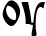

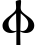

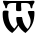

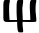

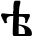

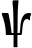

In [8]:
for char in ALPHABET:
    img = generate_char_as_image(char, FONT_PATH, 50)
    display_pillow_image(img)

In [9]:
def otsu_threshold(image):
    image = image.flatten()
    hist = np.bincount(image, minlength=256)  # (256,)
    nonzero = hist.nonzero()[0]  # (N,)
    hist = hist[nonzero] / len(image)  # (N,)
    
    w_0 = hist.cumsum()  # (N,)
    w_1 = 1 - w_0  # (N,)
    
    cumsum = (nonzero * hist).cumsum()  # (N,)
    M_0 = cumsum / w_0  # (N,)
    M_1 = (cumsum[-1] - cumsum) / w_1  # (N,)
    
    grid = nonzero[None].repeat(len(nonzero), axis=0)  # (N, N)
        
    D_0 = grid - M_0[:, None]  # (N, N)
    D_0 = D_0**2 * hist  # (N, N)
    D_0 = np.tril(D_0).sum(1)  # (N,)
    
    D_1 = grid - M_1[:, None]  # (N, M)
    D_1 = D_1**2 * hist  # (N, N)
    D_1 = np.triu(D_1, k=1).sum(1)  # (N,)
    
    D_intra = w_0 * D_0 + w_1 * D_1  # (N,)
    D_inter = w_0 * w_1 * (M_0 - M_1)**2  # (N,)
    
    argmax = np.nanargmax(D_inter / D_intra)
    threshold = nonzero[argmax]
    M_0 = int(M_0[argmax].item())
    M_1 = int(M_1[argmax].item())
    
    return threshold, M_0, M_1


def binarize_by_threshold(poluton, threshold, out=None):
    if out is None:
        out = np.zeros(poluton.shape, dtype=bool)
    out[poluton >= threshold] = True
    return out

def binarize_by_mean(poluton, M_0, M_1, out=None):
    if out is None:
        out = np.zeros(poluton.shape, dtype=bool)
    mean = int(poluton.mean())
    if abs(mean - M_0) > abs(mean - M_1):
        out[:] = True
    return out


def otsu_binarize(poluton):
    threshold = otsu_threshold(poluton)[0]
    result = binarize_by_threshold(poluton, threshold)
    return result

In [10]:
def calc_relative_features(text_image):
    features = []
    
    m, n = text_image.shape
    
    black_weight = text_image.sum()
    black_weight_rel = black_weight / (m * n)
    
    features.append(black_weight_rel)
    
    x_arange = np.arange(1, m + 1)
    y_arange = np.arange(1, n + 1)
    
    x_center = (text_image.T * x_arange).sum() / black_weight
    y_center = (text_image * y_arange).sum() / black_weight
            
    x_center_rel = (x_center - 1) / (m - 1)
    y_center_rel = (y_center - 1) / (n - 1)
    
    features.append(x_center_rel)
    features.append(y_center_rel)
                
    x_axias_moment = ((y_arange - y_center)**2 * text_image).sum()
    y_axias_moment = ((x_arange - x_center)**2 * text_image.T).sum()
    
    x_scale = ((y_arange - (1 + n) / 2)**2).sum() * m
    y_scale = ((x_arange - (1 + m) / 2)**2).sum() * n
    
    x_axias_moment_rel = x_axias_moment / x_scale
    y_axias_moment_rel = y_axias_moment / y_scale
    
    features.append(x_axias_moment_rel)
    features.append(y_axias_moment_rel)
    
    return np.array(features)

In [11]:
feature_names = [
    "black_weight_rel", "x_center_rel", "y_center_rel", "x_axias_moment_rel", "y_axias_moment_rel"
]
table = defaultdict(list)

for char in ALPHABET:
    table["char"].append(char)
    
    img = generate_char_as_image(char, FONT_PATH, 100)
    img = np.asarray(img)
    img = ~otsu_binarize(img)
    
    features = calc_relative_features(img)
    for name, feature_value in zip(feature_names, features):
        table[name].append(feature_value)
        
table = pd.DataFrame(table)

In [12]:
table.sample(n=5, random_state=SEED)

char  black_weight_rel  x_center_rel  y_center_rel  x_axias_moment_rel  \
27    ч          0.408163      0.421035      0.578727            0.272293   
5     є          0.355000      0.492209      0.426895            0.215775   
6     ж          0.460274      0.521630      0.491127            0.310720   
38    ѯ          0.337255      0.501739      0.541352            0.200704   
21    ѹ          0.292744      0.393157      0.485391            0.212833   

    y_axias_moment_rel  
27            0.353495  
5             0.330627  
6             0.488865  
38            0.323120  
21            0.196273

In [13]:
table.to_csv(RELATIVE_FEATURES_PATH)

In [14]:
def plot_char_with_cuts(char):
    img = generate_char_as_image(char, FONT_PATH, 100)
    img = np.asarray(img)
    img = ~otsu_binarize(img)
    
    m, n = img.shape
    
    hor_cuts = img.sum(0) / m
    ver_cuts = img.sum(1) / n
    
    plt.figure(figsize=(10, 10))

    plt.subplot(2, 2, 1)
    plt.barh(np.arange(m), ver_cuts[::-1], tick_label=np.round(ver_cuts).astype(int), height=0.3)
    plt.ylim(0, m - 1)
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(img, cmap="binary", aspect='auto')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.bar(np.arange(n), hor_cuts, tick_label=np.round(hor_cuts).astype(int), width=0.3)
    plt.xlim(0, n - 1)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

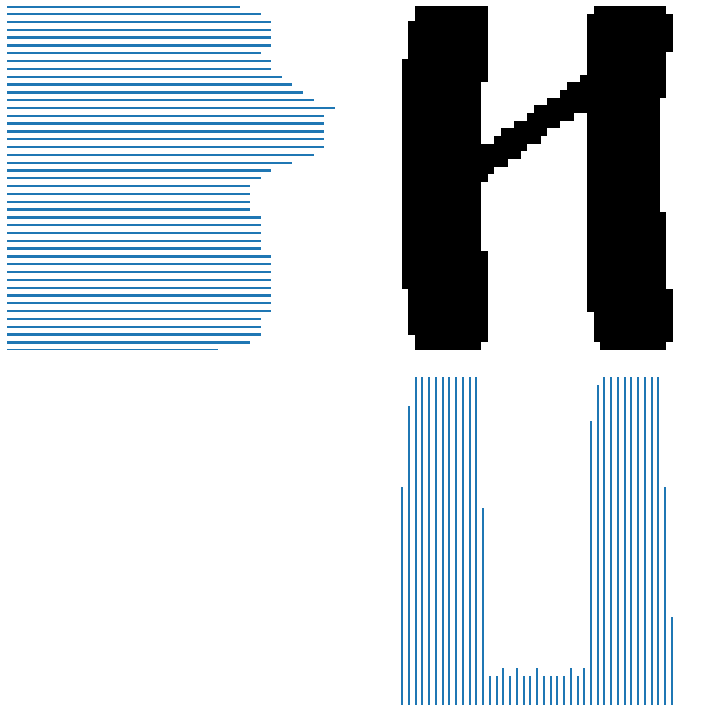

In [15]:
rand_char = random.sample(ALPHABET, 1)[0]
plot_char_with_cuts(rand_char)